In [1]:
%reload_ext autoreload
%autoreload 2
import os

os.environ["PATH"] += ":/opt/homebrew/bin"

# Portein
## Portraits of Proteins

Portein plots 3D proteins according to their best 2D projection (best = greatest area visible), allowing for easy automation of protein visualization.

In [2]:
import portein
import matplotlib.pyplot as plt
import numpy as np
import yaml
from biotite import structure as struct
from biotite.structure import io as bio

portein.compile_numba_functions()

/Users/jay/Projects/portein/portein/rotate.py:23: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  m = find_best_projection(coords)
/Users/jay/Projects/portein/portein/rotate.py:23: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  m = find_best_projection(coords)
/Users/jay/Projects/portein/portein/rotate.py:28: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'F', False, aligned=True))
  matrix = rotate_to_maximize_bb_height(coords[:, :2]) @ matrix


## Orient your protein

Portein uses some linear algebra (for [Optimal rotation of 3D model for 2D projection](https://stackoverflow.com/a/2970340) and [Rotating an object to maximize bounding box height](https://stackoverflow.com/a/47844156)) to find the best 2D projection for the input protein's 3D coordinates. 

**Example orientation:**

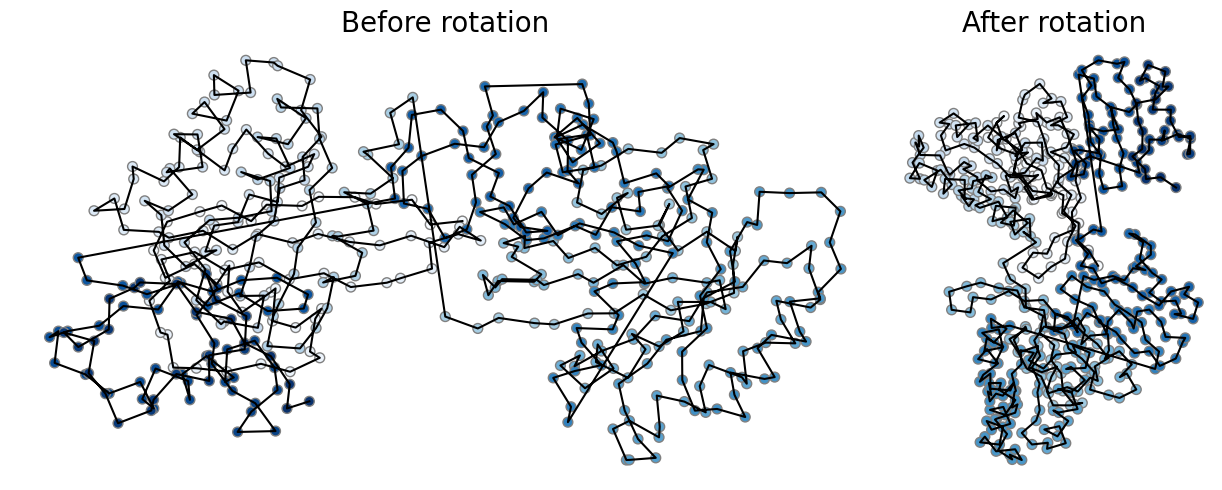

In [3]:
pdb = portein.read_structure("7lc2")
old_coords = pdb[pdb.atom_name == "CA"].coord

# Rotate the protein
pdb_oriented = portein.rotate_protein(pdb)
new_coords = pdb_oriented[pdb_oriented.atom_name == "CA"].coord

# Find the best size of the plot based on the coordinates and a given height (or width)
old_width, old_height = portein.find_size(old_coords, height=5)
new_width, new_height = portein.find_size(new_coords, height=5)

fig, ax = plt.subplots(
    1,
    2,
    figsize=(old_width + new_width, new_height),
    gridspec_kw={"width_ratios": [old_width, new_width]},
)
ax[0].plot(old_coords[:, 0], old_coords[:, 1], "-", c="black")
ax[0].scatter(
    old_coords[:, 0],
    old_coords[:, 1],
    c=np.arange(old_coords.shape[0]),
    s=50,
    cmap="Blues",
    edgecolors="gray",
)
ax[1].plot(new_coords[:, 0], new_coords[:, 1], "-", c="black")
ax[1].scatter(
    new_coords[:, 0],
    new_coords[:, 1],
    c=np.arange(new_coords.shape[0]),
    s=50,
    cmap="Blues",
    edgecolors="gray",
)
ax[0].set_title("Before rotation", fontsize=20)
ax[1].set_title("After rotation", fontsize=20)
ax[0].axis("off")
ax[1].axis("off")
plt.tight_layout()

You can save an oriented version of your protein from the command line as follows:

```sh
portein rotate 7lc2
```

## Plot Pymol ray-traced images

Requires: [pymol](https://github.com/schrodinger/pymol-open-source)

Automatically layer different Pymol representations on top of each other, each one ray-traced separately and then combined with user-defined transparencies. All variables that can be set in Pymol can be passed to the `PymolConfig` object.

In [5]:
# Using some default nice PyMOL settings
with open("configs/pymol_settings.yaml") as f:
    pymol_settings = yaml.safe_load(f)
pymol_settings

{'ambient': 0.5,
 'antialias': 2,
 'cartoon_discrete_colors': True,
 'cartoon_fancy_helices': True,
 'cartoon_sampling': 20,
 'depth_cue': False,
 'hash_max': 300,
 'light_count': 1,
 'ray_opaque_background': False,
 'ray_shadows': False,
 'ray_texture': 0,
 'ray_trace_disco_factor': 1,
 'ray_trace_fog': False,
 'ray_trace_gain': 0,
 'ray_trace_mode': 1,
 'specular': False,
 'surface_quality': 2}

In [6]:
# Rotate the protein, set the width of the plot (height is auto-calculated), and the colormap for the chains (can also be a dictionary of chain: color)
protein_config = portein.ProteinConfig(
    pdb_file="7lc2",
    rotate=True,
    width=1000,
    chain_colormap="Set3",
    output_prefix="examples/7lc2_simple",
)
pymol_class = portein.Pymol(
    protein=protein_config,
    # Single layer of cartoon representation
    layers=[
        portein.PymolConfig(representation="cartoon", pymol_settings=pymol_settings)
    ],
)

# Run PyMOL
image_file = pymol_class.run()

![Simple Pymol example](examples/7lc2_simple_rotated_pymol.png)

To do this from the command line, you need a YAML file with info about the protein:

```YAML
pdb_file: 7lc2
rotate: true
width: 1000
chain_colormap: Set3
output_prefix: examples/7lc2_simple
```

And then:

```sh
portein pymol examples/protein_example_simple.yaml
```

Here's a fancier version with four layers:
- Layer 1 is surface at 0.5 opacity
- Layer 2 is cartoon
- Layer 3 has only some residues displayed as sticks, set by the `selection="highlight"` in `PymolRepresentationConfig` and `highlight_residues` in `ProteinConfig`. 
- Layer 4 shows a ligand as sticks in green

The `selection` attribute can also be any kind of Pymol selection ("all" by default)

In [7]:
protein_config = portein.ProteinConfig(
    pdb_file="7lc2",
    rotate=True,
    output_prefix="examples/7lc2",
    chain_colormap="Set3",
    highlight_residues={
        "A": {"black": [30, 35], "red": list(range(10, 20))},
        "B": {"black": [25], "red": list(range(10, 16))},
    },
    width=1000,
)
layers = [
    portein.PymolConfig(
        representation="surface", pymol_settings=pymol_settings, transparency=0.5
    ),
    portein.PymolConfig(representation="cartoon", pymol_settings=pymol_settings),
    portein.PymolConfig(
        representation="sticks", pymol_settings=pymol_settings, selection="highlight"
    ),
    portein.PymolConfig(
        representation="sticks",
        pymol_settings=pymol_settings,
        selection="resn GNP",
        color="green",
    ),
]

pymol_class = portein.Pymol(protein=protein_config, layers=layers, buffer=10)
image_file = pymol_class.run()

![Pymol example](examples/7lc2_rotated_pymol.png)

This can also be achieved from the command line using YAML config files

```sh
portein pymol examples/protein_example.yaml examples/pymol_layers_example.yaml --buffer 10
```

Here's an example of zooming into a ligand pocket:

In [24]:
# Select the ligand and the pocket residues
pdb = portein.read_structure("7lc2")
ligand = pdb[(pdb.chain_id == "A") & (pdb.res_name == "GNP")]
mask = struct.CellList(pdb, 6).get_atoms(ligand.coord, 6, as_mask=True).any(axis=0)
ligand_pocket = pdb[mask]
proximal_chains = struct.get_chains(ligand_pocket)

# Get best rotation:
rotation, translation = portein.get_best_transformation(
    ligand_pocket.coord.astype(np.float64)
)
pdb_oriented = struct.rotate(struct.translate(pdb, translation), rotation)

# Save only the proximal chains
bio.save_structure(
    "examples/7lc2_rotated_ligand.pdb",
    pdb_oriented[np.isin(pdb_oriented.chain_id, proximal_chains)],
)

protein_config = portein.ProteinConfig(
    pdb_file="examples/7lc2_rotated_ligand.pdb",
    rotate=False,
    output_prefix="examples/7lc2_ligand",
    chain_colormap="white",
    width=1000,
)
layers = [
    portein.PymolConfig(
        representation="surface", pymol_settings=pymol_settings, transparency=0.3
    ),
    portein.PymolConfig(representation="cartoon", pymol_settings=pymol_settings),
    portein.PymolConfig(
        representation="sticks",
        pymol_settings=pymol_settings,
        selection="(chain A and resn GNP)",
        color="green",
    ),
]

pymol_class = portein.Pymol(protein=protein_config, layers=layers)
image_file = pymol_class.run()

![Pymol example](examples/7lc2_ligand_pymol.png)

## Plot `illustrate` images

Requires: [`illustrate`](https://github.com/ccsb-scripps/Illustrate), [`convert`](https://imagemagick.org/script/convert.php)

Uses David Goodsell's [`illustrate`](https://github.com/ccsb-scripps/Illustrate) to generate images. All `illustrate` parameters are user-definable.

In [8]:
protein_config = portein.ProteinConfig(
    pdb_file="7lc2",
    rotate=True,
    output_prefix="examples/7lc2",
    chain_colormap="Set3",
    highlight_residues={
        "A": {"black": [30, 35], "red": list(range(10, 20))},
        "B": {"black": [25], "red": list(range(10, 16))},
    },
    width=1000,
)

illustrate = portein.Illustrate(
    protein_config=protein_config, illustrate_config=portein.IllustrateConfig()
)
image_file = illustrate.run()

![Illustrate example](examples/7lc2_rotated_illustrate.png)

From the command line:
```sh
portein illustrate examples/protein_example.yaml
```

You can pass the illustrate config file as the second argument (See `configs/illustrate.yaml`for defaults)


## Plot secondary structure topology diagram

Requires: `mkdssp`

This runs DSSP to split the protein into its secondary structural elements (SSE) and then uses the start and end coordinates of each SSE to plot (adapted from [this gist](https://gist.github.com/JoaoRodrigues/f9906b343d3acb38e39f2b982b02ecb0))
* helices as waves or cylinders (controlled by `HelixConfig.as_cylinder`)
* beta sheets as arrows
* turns as arcs with circles at the ends

See the `configs` folder for parameter settings available for each plot type.

<Axes: >

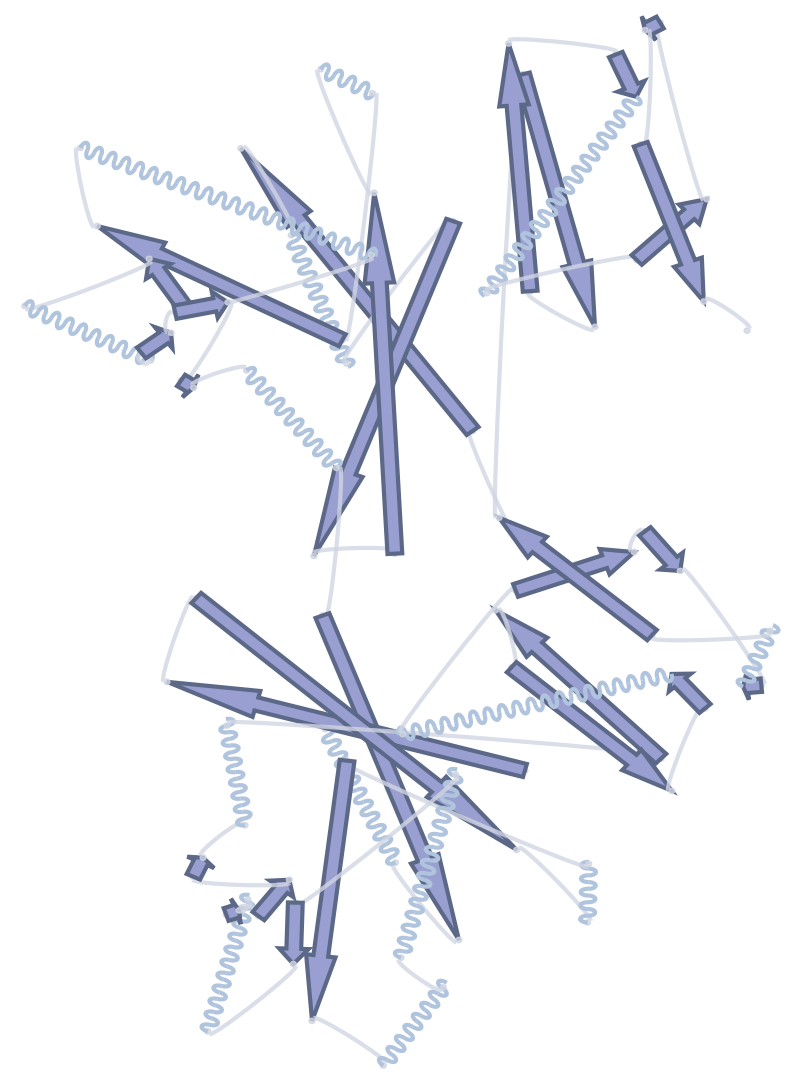

In [ ]:
protein_config = portein.ProteinConfig(
    pdb_file="7lc2", rotate=True, width=1000, output_prefix="examples/7lc2"
)
ss = portein.SecondaryStructure(
    protein_config=protein_config,
    helix_config=portein.HelixConfig(),
    sheet_config=portein.SheetConfig(),
    turn_config=portein.TurnConfig(),
    dpi=100,
)
ss.run()

And from the command line:

```sh
portein secondary 7lc2
```

Use `-h`, `-s` and `-t` to pass helix, turn, and sheet config files

Modify the figure e.g to highlight specific residues using the returned Axes object:

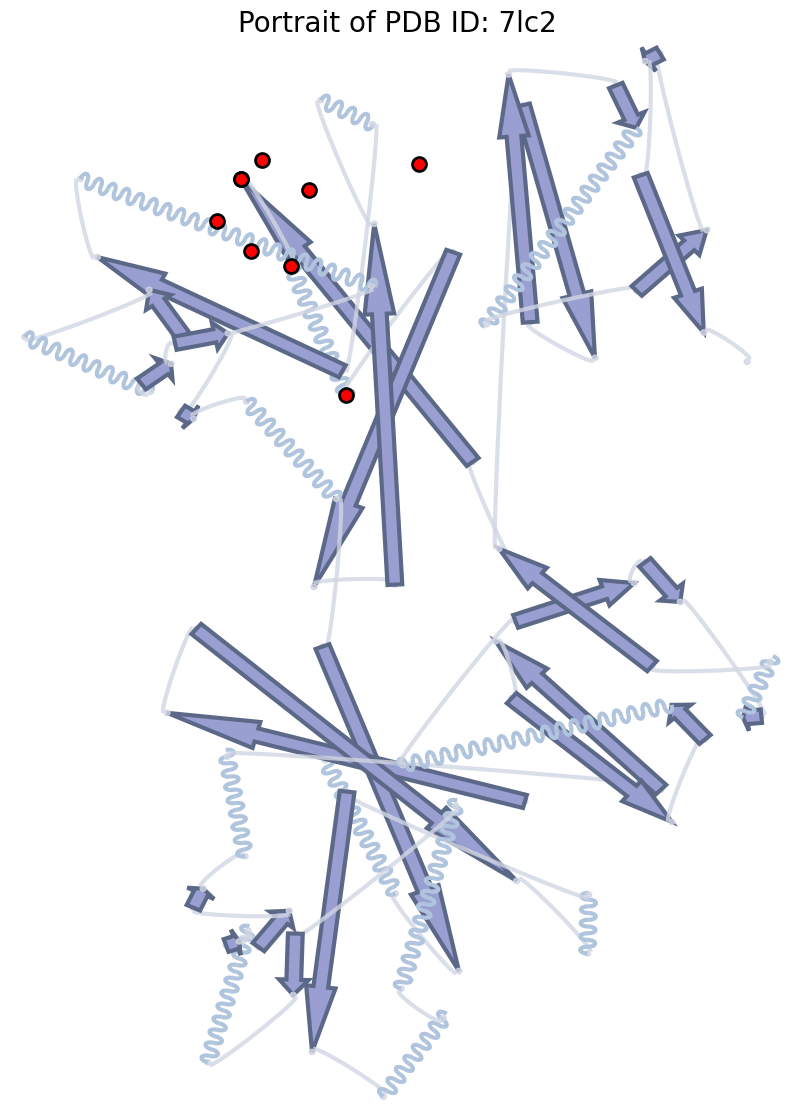

In [10]:
ax = ss.run()
ax.set_title("Portrait of PDB ID: 7lc2", fontsize=20)
highlight_residues = [30, 35, 25, 10, 11, 12, 13, 14, 15]
ax.scatter(
    ss.coords[highlight_residues, 0],
    ss.coords[highlight_residues, 1],
    color="red",
    s=100,
    edgecolor="black",
    linewidth=2,
)

Plot as a linear secondary structure diagram:

<Axes: >

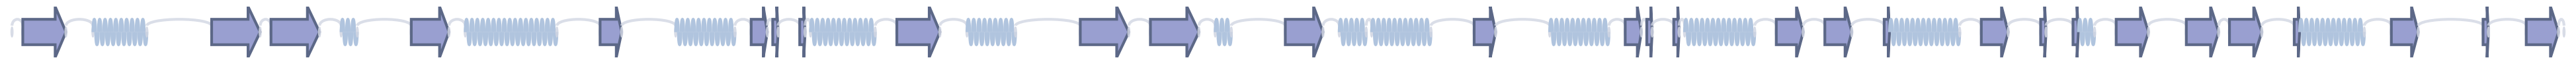

In [11]:
fig, ax = plt.subplots(1, figsize=(50, 1))
ss.run(ax=ax, linear=True)